In [9]:
import os
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter

sns.set_style('ticks')

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

##### Read files and select drugs

In [10]:
ref_type = 'log2_median_ic50_hn' # log2_median_ic50_3f_hn | log2_median_ic50_hn
model_name = 'RWEN' 

# for each patient, if cell cluster is less than 5%, then we don't consider that cluster 
freq_cutoff = 0.05

# shift the dosage as GDSC experiment (Syto60) is less sensitive
dosage_shifted = False

In [11]:
drug_info_df = pd.read_csv('../preprocessed_data/GDSC/hn_drug_stat.csv', index_col=0)
drug_info_df.index = drug_info_df.index.astype(str)

drug_id_name_dict = dict(zip(drug_info_df.index, drug_info_df['Drug Name']))
print (drug_info_df.shape)

(81, 27)


In [12]:
tested_drug_list = [1032, 1007, 133, 201, 1010] + [182, 301, 302]
[d for d in tested_drug_list if d not in drug_info_df.index.astype(int)]

[]

##### Read predicted IC50

In [13]:
norm_type = 'TPM'

In [14]:
cadrres_cluster_df = pd.read_csv('../result/HN_model/{}/{}_pred.csv'.format(norm_type, model_name), index_col=0)
out_dir = '../result/HN_model/{}/'.format(norm_type)

In [15]:
cadrres_cluster_df.head()

,1007,133,201,1010,182,301,302,1012
cluster,,,,,,,,
A1,-9.408460,-6.029518,-11.469267,2.835190,-4.326052,-2.212837,-2.816472,-0.354483
A2,-9.454257,-6.286787,-11.783106,1.652145,-3.675764,-2.277713,-4.730575,-0.613253
B1,-8.610804,-5.822999,-10.011056,3.069076,-0.747959,9.088354,5.539899,-0.177654
B2,-9.238351,-6.119612,-9.166921,3.319112,-1.294344,2.519170,0.776686,0.146506
C1,-9.991132,-6.558564,-12.666164,2.232760,-1.774887,4.421201,0.631304,-0.866772


In [16]:
drug_list = cadrres_cluster_df.columns
cluster_list = cadrres_cluster_df.index
print(len(drug_list), len(cluster_list))

drug_info_df = drug_info_df.loc[drug_list]
cadrres_cluster_df = cadrres_cluster_df[drug_list]

8 24


In [17]:
if dosage_shifted:
    # Shift by 4 uM
    cadrres_cluster_df = cadrres_cluster_df - 2

##### Read cell cluster % in each patient

In [18]:
freq_df = pd.read_excel('../preprocessed_data/HN_patient_specific/percent_patient_tpm_cluster.xlsx', index_col=[0, 1]).reset_index()
freq_df = freq_df.pivot(index='patient_id', columns='cluster', values='percent').fillna(0) / 100

patient_list = freq_df.index

freq_df.head()

cluster,A1,A2,B1,B2,C1,C2,D1,D2,E1,E2,...,F3,G1,G2,H1,I1,I2,J1,J2,K1,L
patient_id,,,,,,,,,,,,,,,,,,,,,
HN120,0.010989,0.005495,0.000000,0.000000,0.000000,0.000000,0.313187,0.175824,0.000000,0.000000,...,0.000000,0.340659,0.120879,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.032967
HN137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005682,0.000000,0.340909,0.085227,...,0.096591,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.011364
HN148,0.000000,0.000000,0.000000,0.000000,0.313514,0.205405,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.459459,0.000000,0.000000,0.0,0.0,0.00000,0.021622
HN159,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.317365,0.185629,0.0,0.0,0.48503,0.011976
HN160,0.000000,0.000000,0.422222,0.414815,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.162963


##### List all pairs of patient and drug

In [19]:
pred_delta_df = pd.DataFrame(cadrres_cluster_df.values - drug_info_df[ref_type].values, columns=drug_list, index=cluster_list)
pred_cv_df = 100 / (1 + (np.power(2, -pred_delta_df)))
pred_kill_df = 100 - pred_cv_df

rows = []
for p in patient_list:
    c_list = freq_df.loc[p][freq_df.loc[p] >= freq_cutoff].index.values
    freqs = freq_df.loc[p][freq_df.loc[p] >= freq_cutoff].values

    ##### freq sum to 1 (not in use) #####
    # freqs = freqs / np.sum(freqs)

    p_pred_delta_weighted = np.matmul(pred_delta_df.loc[c_list].values.T, freqs)
    p_pred_delta_mat = pred_delta_df.loc[c_list].values
    
    p_pred_kill_weighted = np.matmul(pred_kill_df.loc[c_list].values.T, freqs)
    p_pred_kill_mat = pred_kill_df.loc[c_list].values

    for d_i, d_id in enumerate(drug_list):
        rows += [[p, d_id] + ['|'.join(c_list)] + ['|'.join(["{:.14}".format(f) for f in freqs])] + 
                 ['|'.join(["{:.14}".format(f) for f in p_pred_delta_mat[:, d_i]])] + 
                 ["{:.14}".format(p_pred_delta_weighted[d_i])] +
                 ['|'.join(["{:.14}".format(f) for f in p_pred_kill_mat[:, d_i]])] + 
                 ["{:.14}".format(p_pred_kill_weighted[d_i])]
                ]

In [20]:
single_drug_pred_df = pd.DataFrame(rows, columns=['patient', 'drug_id', 'cluster', 'cluster_p', 'cluster_delta', 'delta', 'cluster_kill', 'kill'])
single_drug_pred_df = single_drug_pred_df[['patient', 'drug_id', 'cluster', 'cluster_p', 'cluster_delta', 'delta', 'cluster_kill', 'kill']]
single_drug_pred_df.head()

,patient,drug_id,cluster,cluster_p,cluster_delta,delta,cluster_kill,kill
0,HN120,1007,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,0.056986626834624|-0.5521462503121|0.532688663...,0.18719816837933,49.012625383709|59.452863251762|40.87266962319...,44.327072791571
1,HN120,133,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,-2.8334341716821|-2.6720860912117|-3.778959838...,-3.0281039557461,87.69637799287|86.437921582584|93.209818273866...,85.2974894621
2,HN120,201,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,-4.0213711434516|-3.6385077224033|-3.038971912...,-3.3197975989113,94.199124702299|92.56712528151|89.152897129961...,87.040929163578
3,HN120,1010,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,1.8712695534725|1.0992860185533|3.087297545393...,2.1769243350696,21.465935078167|31.821936069363|10.52739493194...,17.366424347237
4,HN120,182,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,-1.690692592809|-1.3450796341807|-0.8269725475...,-1.173358676562,76.348806194752|71.754940580896|63.95043861070...,66.444651184358


In [21]:
single_drug_pred_df.loc[:, 'drug_name'] = [drug_id_name_dict[d] for d in single_drug_pred_df['drug_id'].values]

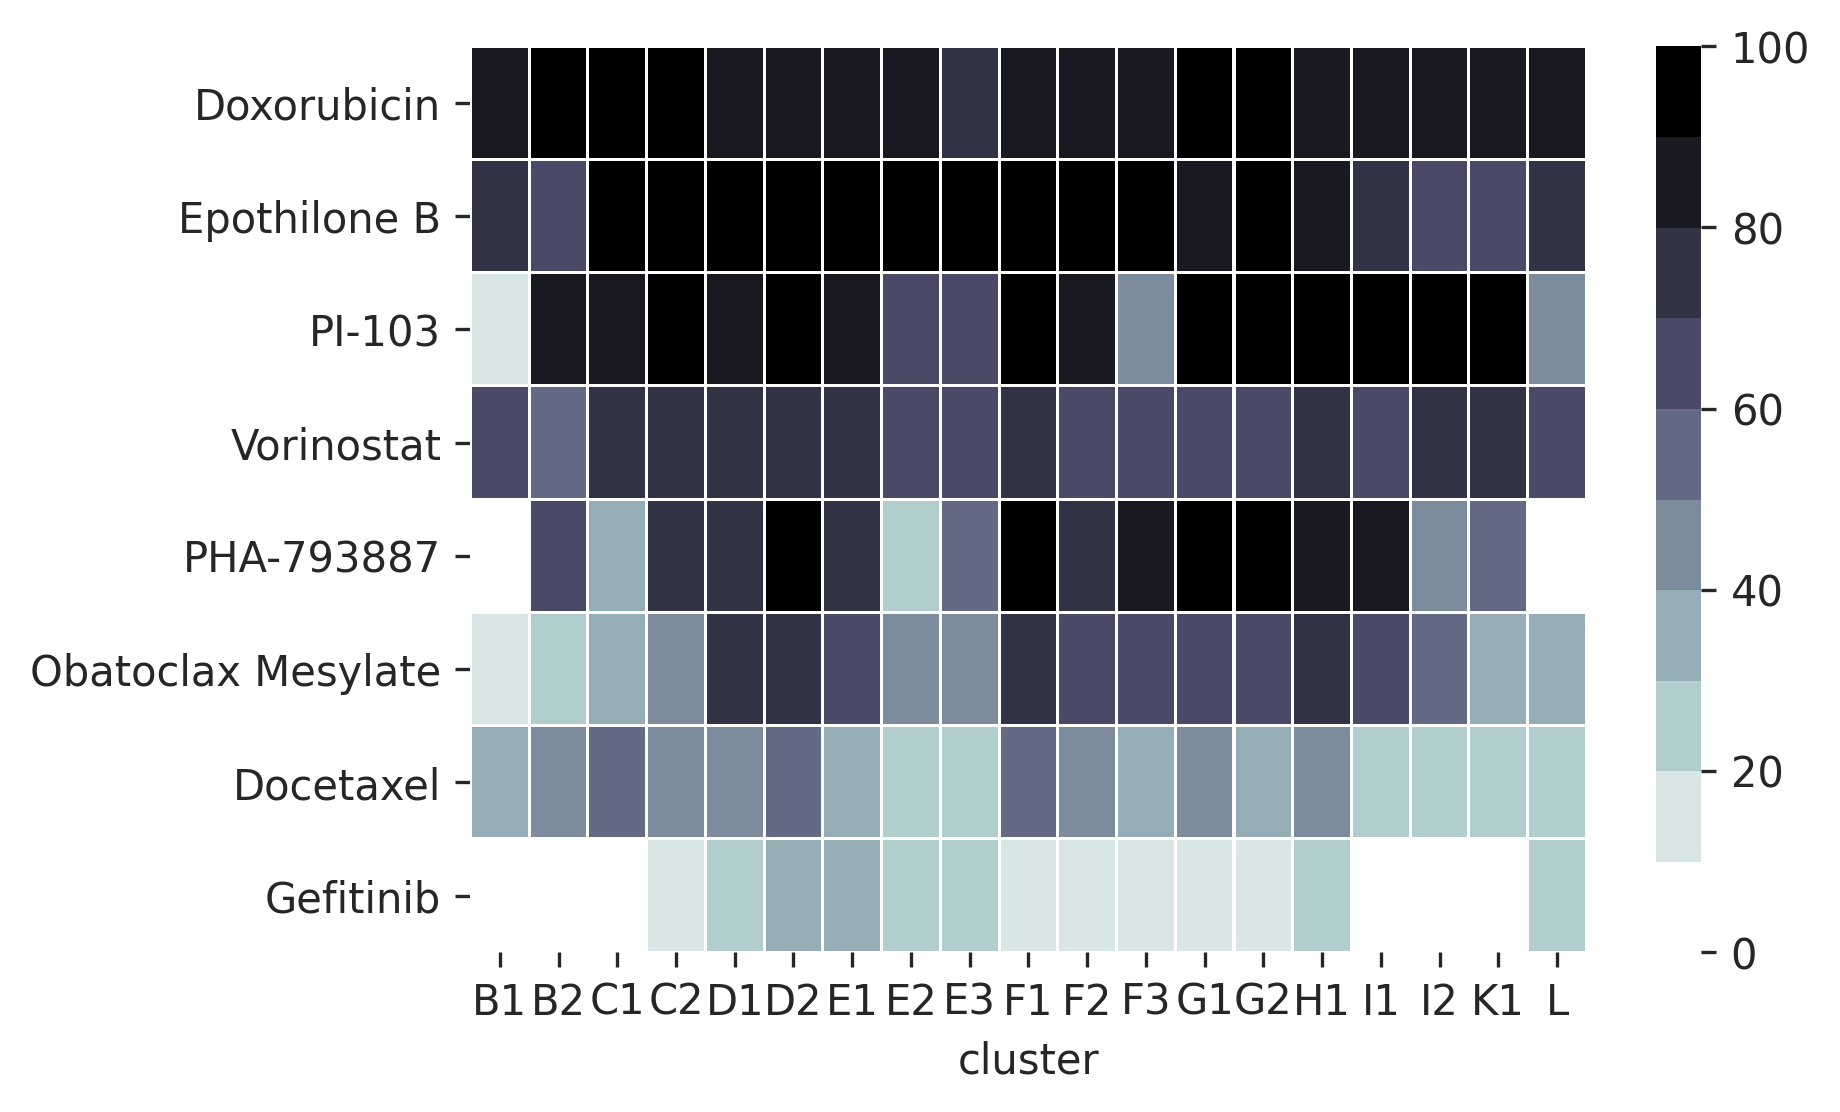

In [22]:
single_drug_id_list = ['1007', '133', '201', '1010', '182', '301', '302', '1012']
single_drug_list = ['Docetaxel', 'Doxorubicin', 'Epothilone B', 'Gefitinib', 'Obatoclax Mesylate', 'PHA-793887', 'PI-103', 'Vorinostat']

temp_df = (freq_df.loc[freq_df.index != 'HN182'] >= freq_cutoff).sum()
selected_clusters = temp_df.index[temp_df > 0]

cmap = plt.cm.get_cmap('bone_r', 10)
selected_kill_df = pred_kill_df.loc[selected_clusters, single_drug_id_list]
selected_kill_df.columns = single_drug_list
selected_kill_df = selected_kill_df[selected_kill_df.sum().sort_values(ascending=False).index]

sns.heatmap(selected_kill_df.T, cmap=cmap, vmin=0, vmax=100, linewidth=0.5)

In [23]:
log2_median_ic50_df = drug_info_df.loc[single_drug_id_list][['Drug Name', ref_type]].reset_index().set_index('Drug Name')
log2_median_ic50_df.loc[selected_kill_df.sum().sort_values(ascending=False).index]

,index,log2_median_ic50_hn
Doxorubicin,133,-2.812230
Epothilone B,201,-8.520806
PI-103,302,3.056464
Vorinostat,1012,0.711127
PHA-793887,301,3.606539
Obatoclax Mesylate,182,-2.958665
Docetaxel,1007,-9.792998
Gefitinib,1010,-1.374969


In [24]:
print (ref_type)
log2_median_ic50s = log2_median_ic50_df.loc[selected_kill_df.sum().sort_values(ascending=False).index][ref_type].values
median_ic50s = np.power(2, log2_median_ic50s)

for x in median_ic50s:
    print ('{:f}'.format(x))


log2_median_ic50_hn
0.142375
0.002723
8.319312
1.637083
12.180817
0.128633
0.001127
0.385561


In [25]:
temp_df = freq_df.loc[freq_df.index != 'HN182'].stack().reset_index()
temp_df = temp_df[temp_df[0] >= freq_cutoff]
patient_cluster_dict = dict(zip(temp_df['cluster'], temp_df['patient_id']))

In [26]:
patient_list = sorted(list(set(temp_df['patient_id'])))
cluster_list = temp_df['cluster'].values

cmap = plt.cm.get_cmap('tab10', 10)
patient_color_dict = dict(zip(patient_list, [cmap(c) for c in range(len(patient_list))]))

In [27]:
patient_list

['HN120', 'HN137', 'HN148', 'HN159', 'HN160']

In [28]:
col_colors = [patient_color_dict[patient_cluster_dict[c]] for c in cluster_list]

In [ ]:
cmap = plt.cm.get_cmap('bone_r', 11)
cg = sns.clustermap(selected_kill_df.T[cluster_list], cmap=cmap, vmin=-10, vmax=100, linewidth=0.5, row_cluster=False, col_cluster=False, col_colors=col_colors, figsize=(8,5.5))

_ = cg.ax_heatmap.set_xlabel('Cluster ID')
plt.tight_layout()
# _ = cg.cax.set_visible(False)

cg.savefig('../figure/Fig4A_heatmap_cluster_pred.svg')

Save results

In [ ]:
if dosage_shifted:
    single_drug_pred_df.to_csv(out_dir + 'pred_drug_kill_{}_{}_shifted.csv'.format(ref_type, model_name), index=False)
else:
    single_drug_pred_df.to_csv(out_dir + 'pred_drug_kill_{}_{}.csv'.format(ref_type, model_name), index=False)